In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [228]:
import scipy
import scipy.ndimage
from scipy.stats import skewnorm

In [229]:
from opensimplex import OpenSimplex

In [268]:
# Generates a cultive field, pass in a "base field" and it will assign a new type of cultive
# to the areas where the noise_filter parameter passes the test
# The category represents the "id" of the cultive

def gen_cultive(field, noise_generator, noise_freq, noise_filter, category):
    for x in range(1,field.shape[0]):
        for y in range(1,field.shape[1]):
            nv = noise_generator.noise2d( noise_freq * x, noise_freq * y)
            if nv > noise_filter:
                field[x,y] = category
    return field

In [254]:
def makeGaussian(size, fwhm = (3., 3.), center=None):
    """ Make a square gaussian kernel.

    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """

    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]

    if center is None:
        x0 = y0 = int(size / 2.)
    else:
        x0 = center[0]
        y0 = center[1]

    return np.exp((x0-x) / fwhm[0]) + np.exp(-4.*np.log(2) * ((y-y0)**2 / fwhm[1]) )

In [255]:
seed = numpy.random.randint(1000)
tmp = OpenSimplex(seed=seed)
seed2 = numpy.random.randint(1000)
tmp2 = OpenSimplex(seed=seed2)

In [269]:
# Generate a cultive map
# This is the base cultive, id=1
wfield = np.full( (1000, 1000), 1)

# Then another cultive with id=2
gen_cultive(wfield, tmp, 0.004, 0.05, 2);

# And a final with id=3
gen_cultive(wfield, tmp2, 0.0045, 0.25, 3);


/home/yanesl/.local/lib/python3.5/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full((1000, 1000), 1) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


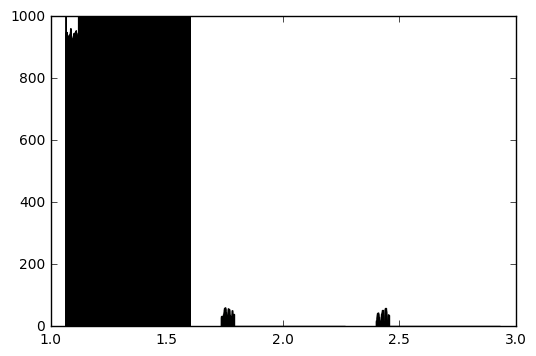

In [262]:
# Here you can study the frequencies of each type of cultive
plt.hist(wfield, bins=3);

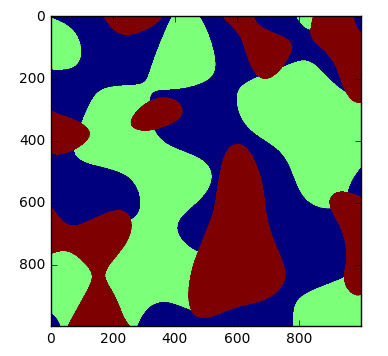

In [270]:
# Random cultive representation map
plt.imshow(wfield)

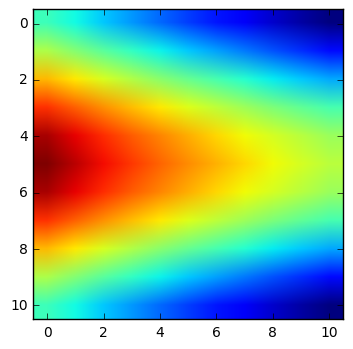

In [271]:
plt.imshow(makeGaussian(11, fwhm=(20,60)))

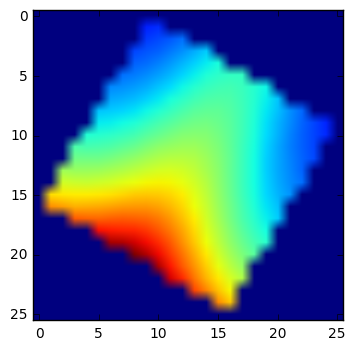

In [272]:
# Here we generate the infectivity distribution

# makeGaussian(...) retruns a gaussian of "infected_range" size and \theta_x, \theta_y are the distribution means

# After that we can rotate the gaussian to incorporate the direction of the "wind".
# theta_x and theta_y have to change according to the x and y magnitude vectors of the wind

infection_range = 19
theta_x = 10.
theta_y = 100.
wind_angle = 60.
plt.imshow(scipy.ndimage.interpolation.rotate(makeGaussian(infection_range, fwhm=(theta_x, theta_y)), wind_angle))

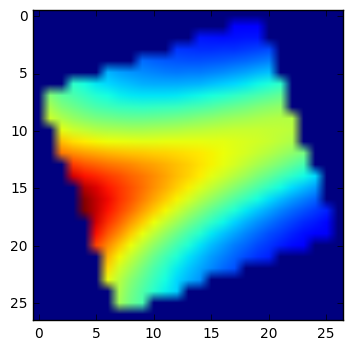

In [273]:
plt.imshow(scipy.ndimage.interpolation.rotate(makeGaussian(21, fwhm=(10., 100.), center=(0, 10)), 20))

In [338]:
# Start writing the infection model

infected_field = numpy.zeros( (1000,1000) )

# New crop infection rate
infection_rate = 0.02

# New infection site probability
infection_site_rate = 0.08

# Array of (x,y) position of initial infection sites, gaussian distributed infection probabilities centered at (x,y)
infection_sites = []

# Infection range is the size of the gaussian
infection_range = 19

# Wind direction vector (x,y) the magnitude can be extracted from the coordinates
# The wind can change over time and will be used to modify rotate, scale and/or recenter the gaussian distributions
wind = (0,0)


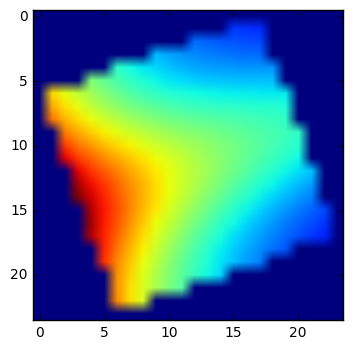

In [339]:
plt.imshow(gaussian)

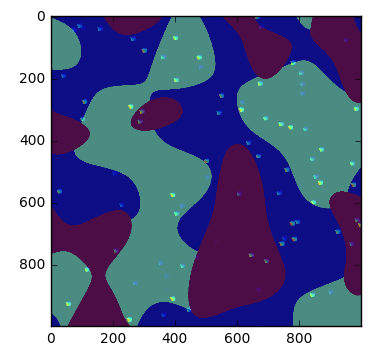

In [340]:
# You can rerun this step to look at how the pathogen spreads over time
h_irange=int(infection_range/2)

for t in range(1,1000):
    p = numpy.random.rand()
    # The parameters for the gaussian function are to be modified by the wind direction and strength
    gaussian = scipy.ndimage.interpolation.rotate(makeGaussian(infection_range, fwhm=(10., 100.)), 20)
    
    
    if p<infection_site_rate:
        # Place a new random infection site in the field
        infection_sites.append( (numpy.random.randint(wfield.shape[0]), numpy.random.randint(wfield.shape[1])) )
    
    # For each infection site, increase the severity of the pixel
    for infection_site in infection_sites:
        for isx in range(-h_irange, h_irange):
            # The modulus is to stay within bounds
            x = (infection_site[0]+isx) % infected_field.shape[0]
            for isy in range(-h_irange, h_irange):
                y = (infection_site[1]+isy) % infected_field.shape[1]
                infection_prob = gaussian[isx+h_irange,isy+h_irange] * 0.1/wfield[x,y] # Prob * 1./category
                infected_field[x][y] += 0 if infection_prob*numpy.random.rand()<infection_rate else gaussian[isx+h_irange,isy+h_irange]

# Clear the infection_sites before doing a new timestep
infection_sites=[]
plt.imshow(infected_field, alpha=0.9)
plt.imshow(wfield, alpha=0.5)

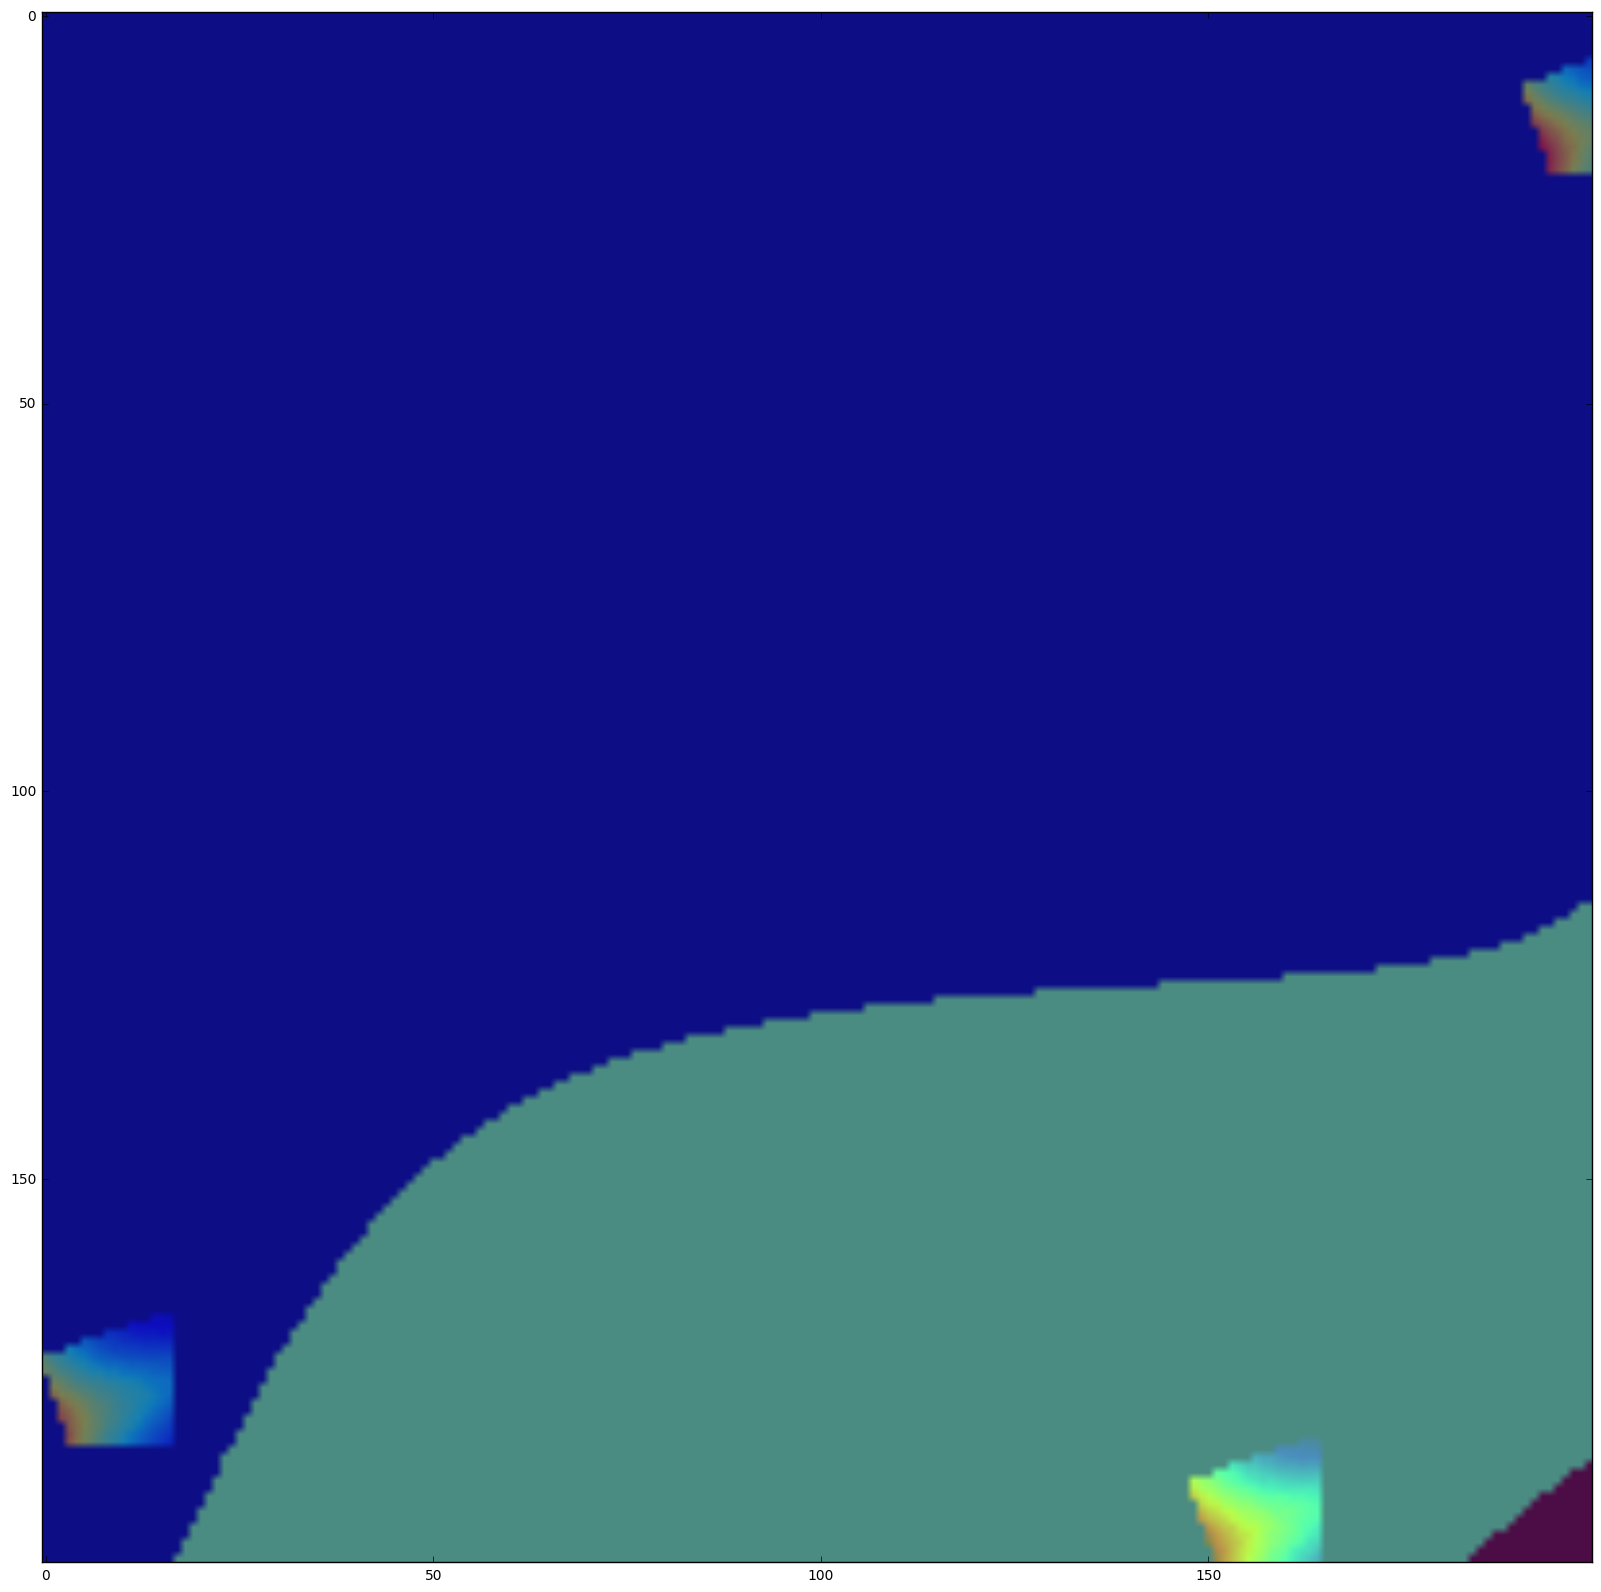

In [341]:
plt.figure(figsize=(20,20))
plt.imshow(infected_field[100:300, 100:300], alpha=0.9)
plt.imshow(wfield[100:300, 100:300], alpha=0.5)